In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [3]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [4]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [5]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [6]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [7]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [8]:
trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [10]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [11]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

<h1>LSTM 1</h1>

In [12]:
# Model 1
model = Sequential()
model.add(LSTM(128, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               70656     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 87942 (343.52 KB)
Trainable params: 87942 (343.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 41s 671ms/step - loss: 1.2550 - accuracy: 0.4728 - val_loss: 0.9469 - val_accuracy: 0.5925
Epoch 2/10
58/58 [==============================] - 35s 594ms/step - loss: 0.8077 - accuracy: 0.6696 - val_loss: 0.6282 - val_accuracy: 0.7362
Epoch 3/10
58/58 [==============================] - 34s 584ms/step - loss: 0.6376 - accuracy: 0.7431 - val_loss: 0.7231 - val_accuracy: 0.7212
Epoch 4/10
58/58 [==============================] - 33s 566ms/step - loss: 0.6077 - accuracy: 0.7616 - val_loss: 0.5359 - val_accuracy: 0.7910
Epoch 5/10
58/58 [==============================] - 34s 574ms/step - loss: 0.4788 - accuracy: 0.8263 - val_loss: 0.3360 - val_accuracy: 0.8858
Epoch 6/10
58/58 [==============================] - 21s 368ms/step - loss: 0.3062 - accuracy: 0.8964 - val_loss: 0.2409 - val_accuracy: 0.9048
Epoch 7/10
58/58 [==============================] - 21s 355ms/step - loss: 0.2194 - accuracy: 0.9227 - val_loss: 0.2082 - val_accuracy: 0.9170

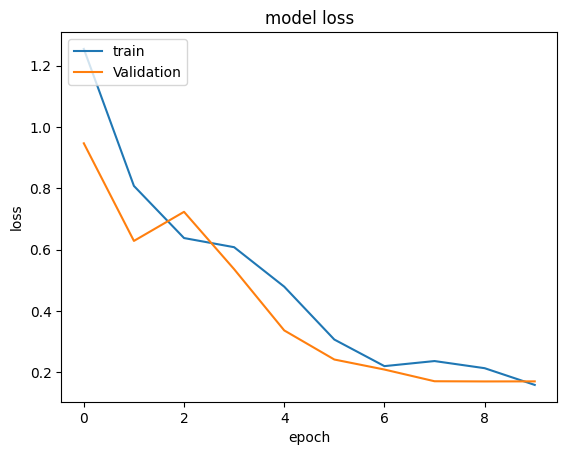

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

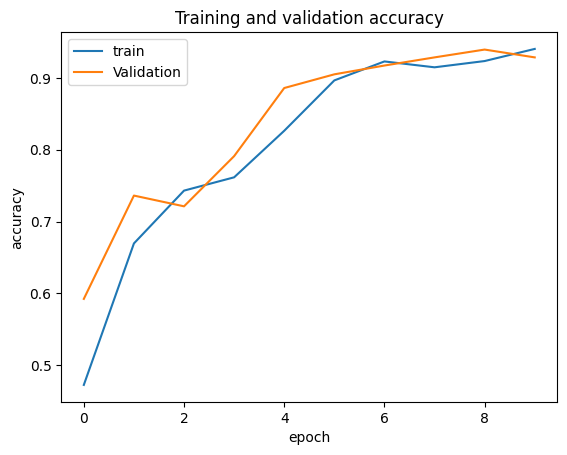

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 12s 119ms/step
[[444  13  39   0   0   0]
 [ 32 414  25   0   0   0]
 [  5   1 412   1   1   0]
 [  0  25   0 279 187   0]
 [  6   0   0  31 495   0]
 [  0  27   0   0   0 510]]
0.8666440447913132
0.8627923052440842
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       496
           1       0.86      0.88      0.87       471
           2       0.87      0.98      0.92       420
           3       0.90      0.57      0.70       491
           4       0.72      0.93      0.81       532
           5       1.00      0.95      0.97       537

    accuracy                           0.87      2947
   macro avg       0.88      0.87      0.86      2947
weighted avg       0.88      0.87      0.86      2947



<Axes: >

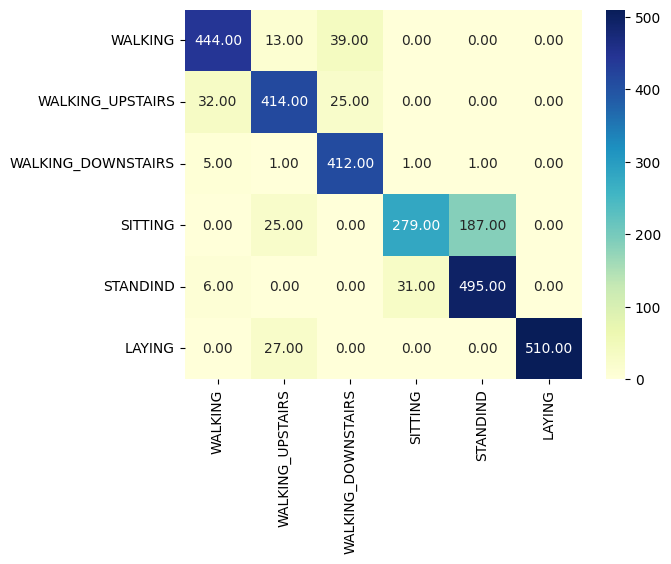

In [16]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>LSTM 2</h1>

In [17]:
# Model 2
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128, 128)          70656     
                                                                 
 dropout_1 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                                 
Total params: 219526 (857.52 KB)
Trainable params: 219

In [18]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 102s 2s/step - loss: 1.1751 - accuracy: 0.5022 - val_loss: 0.8430 - val_accuracy: 0.6496
Epoch 2/10
58/58 [==============================] - 57s 990ms/step - loss: 0.6675 - accuracy: 0.7144 - val_loss: 0.5475 - val_accuracy: 0.7625
Epoch 3/10
58/58 [==============================] - 57s 987ms/step - loss: 0.5064 - accuracy: 0.7960 - val_loss: 0.4064 - val_accuracy: 0.8531
Epoch 4/10
58/58 [==============================] - 59s 1s/step - loss: 0.3933 - accuracy: 0.8611 - val_loss: 0.2981 - val_accuracy: 0.8880
Epoch 5/10
58/58 [==============================] - 52s 908ms/step - loss: 0.2567 - accuracy: 0.9098 - val_loss: 0.1884 - val_accuracy: 0.9220
Epoch 6/10
58/58 [==============================] - 60s 1s/step - loss: 0.1992 - accuracy: 0.9297 - val_loss: 0.1591 - val_accuracy: 0.9411
Epoch 7/10
58/58 [==============================] - 57s 987ms/step - loss: 0.1518 - accuracy: 0.9434 - val_loss: 0.1431 - val_accuracy: 0.9497
Epoch 8

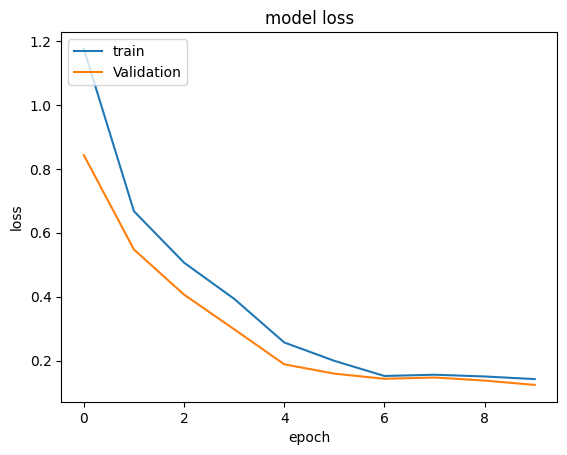

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

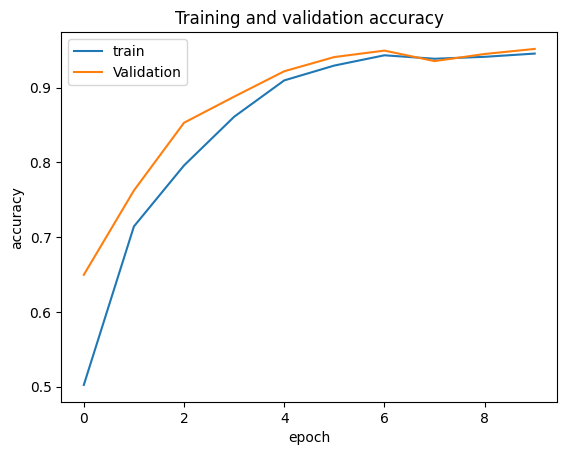

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 14s 137ms/step
[[470   5  21   0   0   0]
 [ 59 398  14   0   0   0]
 [  0   2 418   0   0   0]
 [  1  25   0 383  82   0]
 [  3   2   0  79 448   0]
 [  0  27   0   0   0 510]]
0.8914149983033594
0.8907652601890315
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       496
           1       0.87      0.85      0.86       471
           2       0.92      1.00      0.96       420
           3       0.83      0.78      0.80       491
           4       0.85      0.84      0.84       532
           5       1.00      0.95      0.97       537

    accuracy                           0.89      2947
   macro avg       0.89      0.89      0.89      2947
weighted avg       0.89      0.89      0.89      2947



<Axes: >

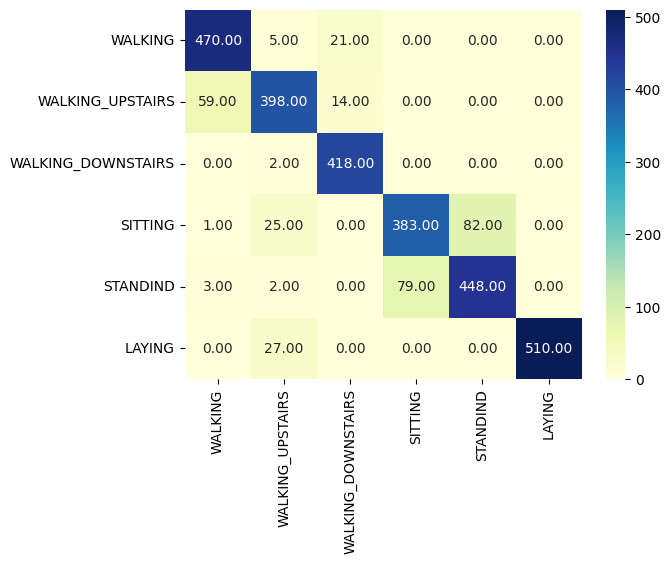

In [21]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>LSTM 3</h1>



In [22]:
# Model 3
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128, 128)          70656     
                                                                 
 dropout_3 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_4 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_4 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)              

In [23]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 89s 1s/step - loss: 1.1795 - accuracy: 0.5045 - val_loss: 0.8500 - val_accuracy: 0.6573
Epoch 2/10
58/58 [==============================] - 82s 1s/step - loss: 0.7479 - accuracy: 0.6752 - val_loss: 0.5752 - val_accuracy: 0.7416
Epoch 3/10
58/58 [==============================] - 83s 1s/step - loss: 0.6062 - accuracy: 0.7359 - val_loss: 0.5536 - val_accuracy: 0.7475
Epoch 4/10
58/58 [==============================] - 86s 1s/step - loss: 0.5021 - accuracy: 0.7745 - val_loss: 0.4942 - val_accuracy: 0.8010
Epoch 5/10
58/58 [==============================] - 86s 1s/step - loss: 0.3589 - accuracy: 0.8679 - val_loss: 0.2279 - val_accuracy: 0.9130
Epoch 6/10
58/58 [==============================] - 84s 1s/step - loss: 0.2906 - accuracy: 0.8949 - val_loss: 0.1981 - val_accuracy: 0.9270
Epoch 7/10
58/58 [==============================] - 88s 2s/step - loss: 0.2503 - accuracy: 0.9112 - val_loss: 0.2234 - val_accuracy: 0.9193
Epoch 8/10
58/58 [==

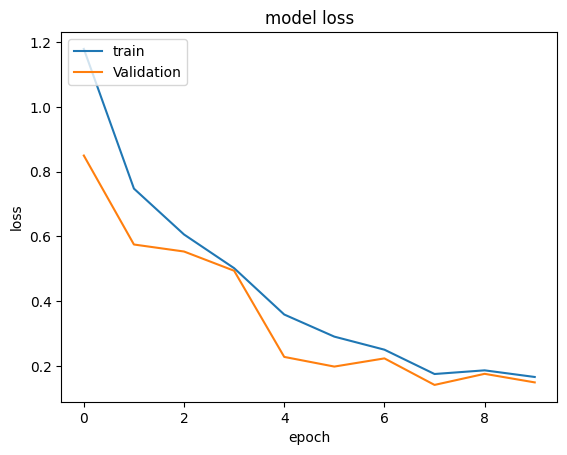

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

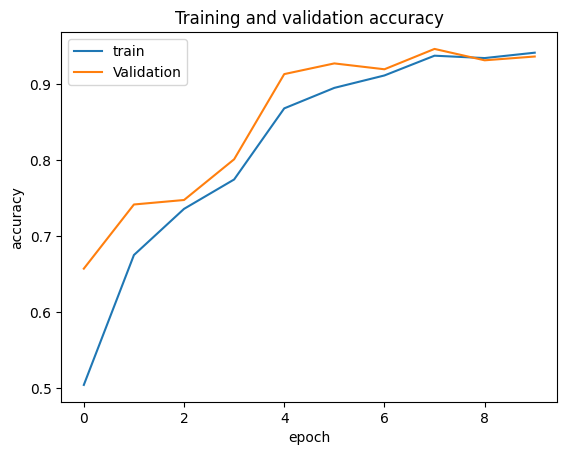

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 24s 242ms/step
[[470  17   9   0   0   0]
 [ 56 409   6   0   0   0]
 [ 11   5 404   0   0   0]
 [  1  24   0 365 100   1]
 [  2   0   0  65 465   0]
 [  0  27   0   0   0 510]]
0.8900576857821514
0.8895957198790354
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       496
           1       0.85      0.87      0.86       471
           2       0.96      0.96      0.96       420
           3       0.85      0.74      0.79       491
           4       0.82      0.87      0.85       532
           5       1.00      0.95      0.97       537

    accuracy                           0.89      2947
   macro avg       0.89      0.89      0.89      2947
weighted avg       0.89      0.89      0.89      2947



<Axes: >

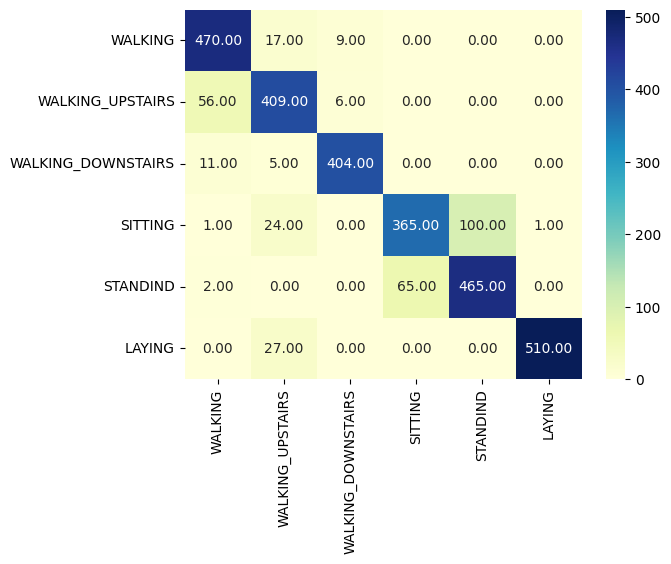

In [26]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>LSTM 4</h1>

In [27]:
# Model 4
model = Sequential()
model.add(LSTM(128, return_sequences=True , input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=True ))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 128, 128)          70656     
                                                                 
 dropout_6 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_7 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_7 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_8 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_8 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_9 (LSTM)               (None, 128)              

In [28]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 138s 2s/step - loss: 1.1442 - accuracy: 0.5056 - val_loss: 0.8758 - val_accuracy: 0.5680
Epoch 2/10
58/58 [==============================] - 125s 2s/step - loss: 0.6507 - accuracy: 0.7073 - val_loss: 0.5653 - val_accuracy: 0.7244
Epoch 3/10
58/58 [==============================] - 114s 2s/step - loss: 0.5540 - accuracy: 0.7458 - val_loss: 0.4698 - val_accuracy: 0.7865
Epoch 4/10
58/58 [==============================] - 122s 2s/step - loss: 0.4634 - accuracy: 0.7773 - val_loss: 0.4739 - val_accuracy: 0.7575
Epoch 5/10
58/58 [==============================] - 112s 2s/step - loss: 0.4204 - accuracy: 0.7934 - val_loss: 0.4482 - val_accuracy: 0.8105
Epoch 6/10
58/58 [==============================] - 121s 2s/step - loss: 0.3809 - accuracy: 0.8165 - val_loss: 0.2678 - val_accuracy: 0.8885
Epoch 7/10
58/58 [==============================] - 123s 2s/step - loss: 0.2657 - accuracy: 0.9045 - val_loss: 0.1824 - val_accuracy: 0.9383
Epoch 8/10
58

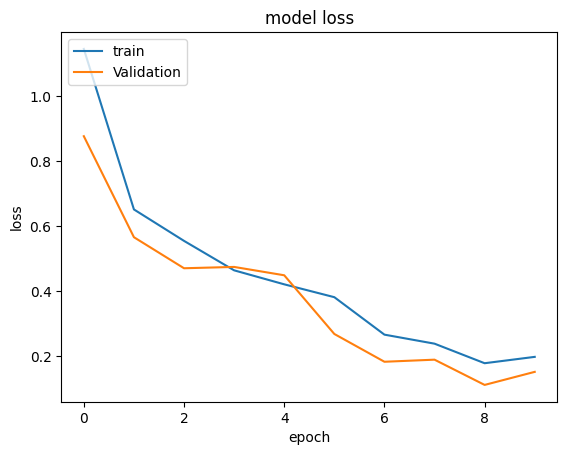

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

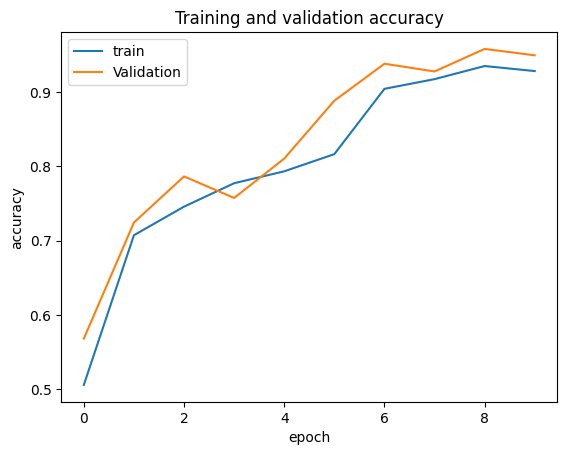

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 30s 303ms/step
[[456  33   4   0   3   0]
 [ 21 447   2   0   0   1]
 [  1  16 403   0   0   0]
 [  0   5   0 405  81   0]
 [  0   0   0 117 415   0]
 [  0  20   0   0   0 517]]
0.8968442483881914
0.8973344113960149
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       496
           1       0.86      0.95      0.90       471
           2       0.99      0.96      0.97       420
           3       0.78      0.82      0.80       491
           4       0.83      0.78      0.81       532
           5       1.00      0.96      0.98       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947



<Axes: >

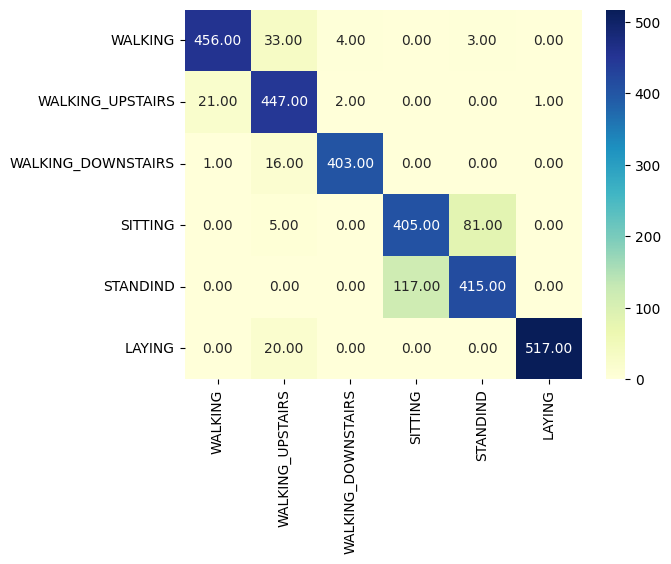

In [31]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>LSTM 5</h1>

In [32]:
# Model 5
model = Sequential()
model.add(LSTM(128, return_sequences=True , input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=True ))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 128, 128)          70656     
                                                                 
 dropout_10 (Dropout)        (None, 128, 128)          0         
                                                                 
 lstm_11 (LSTM)              (None, 128, 128)          131584    
                                                                 
 dropout_11 (Dropout)        (None, 128, 128)          0         
                                                                 
 lstm_12 (LSTM)              (None, 128, 128)          131584    
                                                                 
 dropout_12 (Dropout)        (None, 128, 128)          0         
                                                                 
 lstm_13 (LSTM)              (None, 128, 128)         

In [33]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 166s 3s/step - loss: 1.3015 - accuracy: 0.4270 - val_loss: 1.0875 - val_accuracy: 0.5626
Epoch 2/10
58/58 [==============================] - 152s 3s/step - loss: 0.8163 - accuracy: 0.6489 - val_loss: 0.6239 - val_accuracy: 0.7049
Epoch 3/10
58/58 [==============================] - 148s 3s/step - loss: 0.5867 - accuracy: 0.7314 - val_loss: 0.4416 - val_accuracy: 0.7874
Epoch 4/10
58/58 [==============================] - 158s 3s/step - loss: 0.4711 - accuracy: 0.7780 - val_loss: 0.5248 - val_accuracy: 0.7584
Epoch 5/10
58/58 [==============================] - 161s 3s/step - loss: 0.4094 - accuracy: 0.7911 - val_loss: 0.4451 - val_accuracy: 0.7575
Epoch 6/10
58/58 [==============================] - 164s 3s/step - loss: 0.3963 - accuracy: 0.7984 - val_loss: 0.4143 - val_accuracy: 0.7901
Epoch 7/10
58/58 [==============================] - 165s 3s/step - loss: 0.3682 - accuracy: 0.7986 - val_loss: 0.3398 - val_accuracy: 0.7951
Epoch 8/10
58

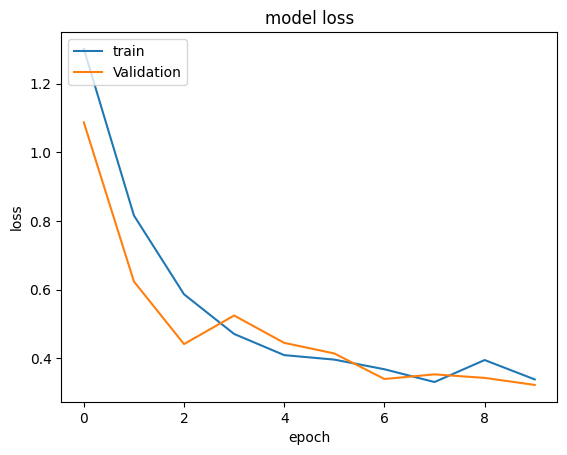

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

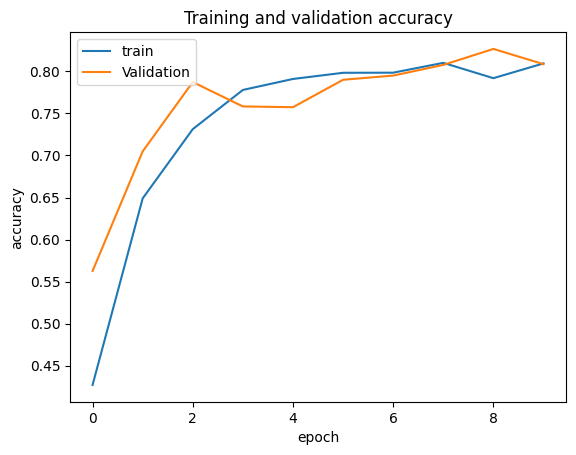

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 36s 361ms/step
[[442  43   7   0   4   0]
 [  3 464   4   0   0   0]
 [  0 420   0   0   0   0]
 [  1   8   0 373 106   3]
 [  2   0   0  64 466   0]
 [  0   0   0   0   0 537]]
0.7743467933491687
0.7305909333140573
              precision    recall  f1-score   support

           0       0.99      0.89      0.94       496
           1       0.50      0.99      0.66       471
           2       0.00      0.00      0.00       420
           3       0.85      0.76      0.80       491
           4       0.81      0.88      0.84       532
           5       0.99      1.00      1.00       537

    accuracy                           0.77      2947
   macro avg       0.69      0.75      0.71      2947
weighted avg       0.71      0.77      0.73      2947



<Axes: >

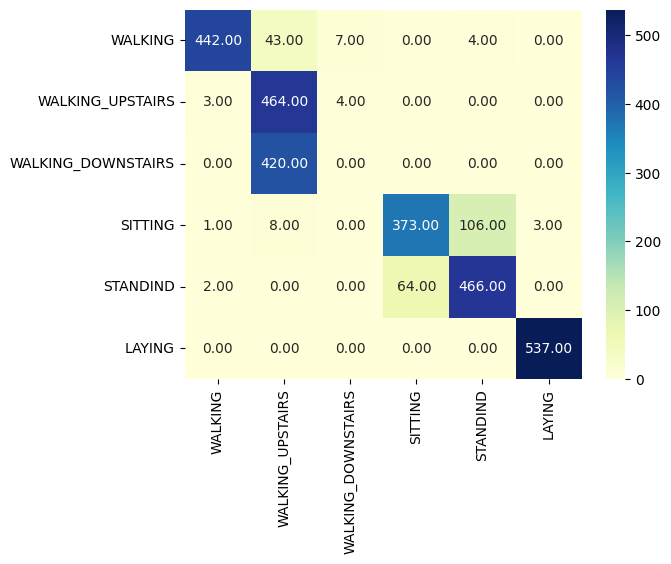

In [36]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')